# Emukit tutorials on experimental design

## Load default libraries

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)
import matplotlib.pyplot as plt

## Make a Latin Hypercuber

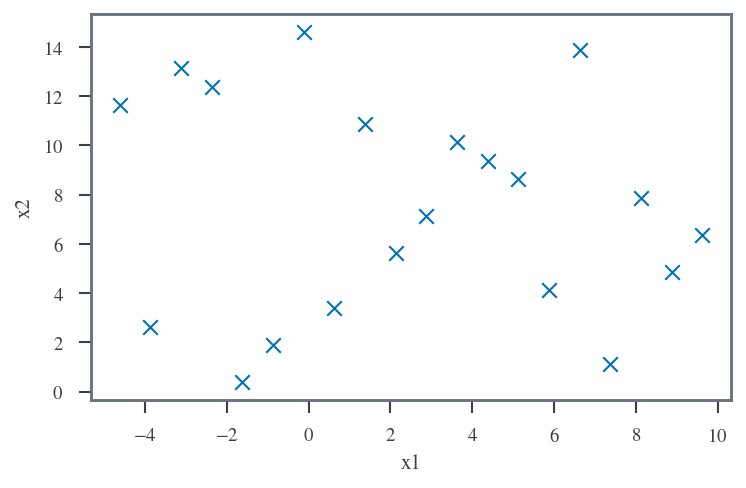

In [3]:
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace(
    [ContinuousParameter("x1", -5, 10), ContinuousParameter("x2", 0, 15)]
)
design = LatinDesign(parameter_space) 
num_data_points = 20
X = design.get_samples(num_data_points)

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Sobol Sequence equivalent

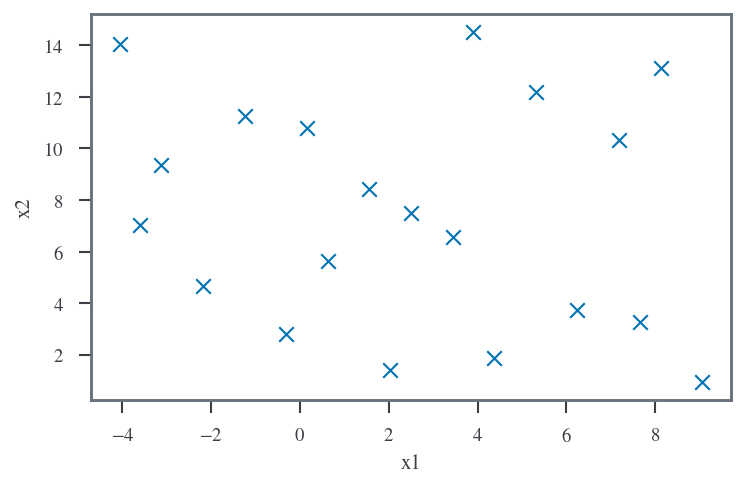

In [4]:
from emukit.core.initial_designs.sobol_design import SobolDesign

design = SobolDesign(parameter_space) 
X1 = design.get_samples(num_data_points)
plt.scatter(X1[:, 0], X1[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Emukit test function

In [5]:
from emukit.test_functions import branin_function

f, _ = branin_function()

## Model selected data points as a Gaussian Process

In [6]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

Y = f(X)
model_gpy = GPRegression(X, Y)
model_emukit = GPyModelWrapper(model_gpy)

## Look at Gaussian Process variance

In [7]:
from emukit.experimental_design.acquisitions import ModelVariance

model_variance = ModelVariance(model=model_emukit)

Text(0, 0.5, 'cov')

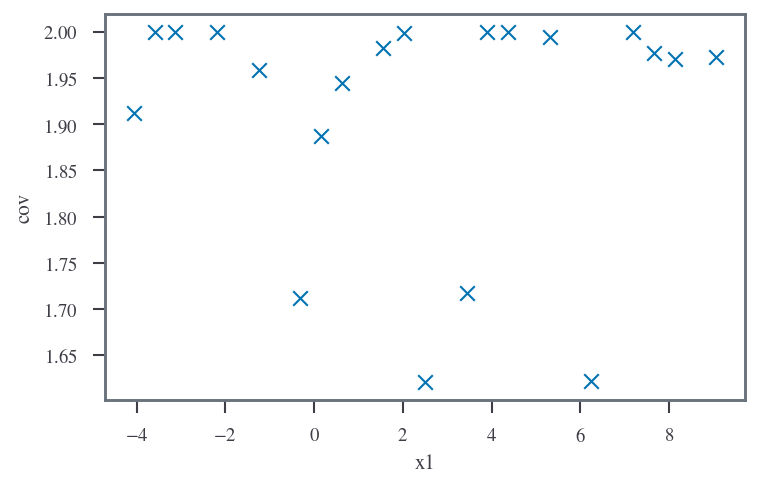

In [8]:
x = X1[:, 0]
_, y_cov = model_variance.model.predict(X1)
plt.scatter(X1[:, 0], y_cov, marker="x")
plt.xlabel("x1")
plt.ylabel("cov")

## Set-up experimental design loop

In [9]:
from emukit.experimental_design import ExperimentalDesignLoop

expdesign_loop = ExperimentalDesignLoop(
    model=model_emukit, space=parameter_space, acquisition=model_variance, batch_size=5
)

In [10]:
ExperimentalDesignLoop?

In [11]:
ps_defaults?

##  ML in the Physical world example

In [12]:
import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

In [13]:
x_min = -30.0
x_max = 30.0

x_data = np.random.uniform(x_min, x_max, (10, 1))
y_data = np.sin(x_data) + np.random.randn(10, 1) * 0.05

In [15]:
emukit_model = SimpleGaussianProcessModel(x_data, y_data)

In [16]:
p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])

In [17]:
loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 30)
plot_min = -40.0
plot_max = 40.0
real_x = np.arange(plot_min, plot_max, 0.2)
real_y = np.sin(real_x)

In [18]:
predicted_y = []
predicted_std = []
for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()

In [ ]:
def plot_between

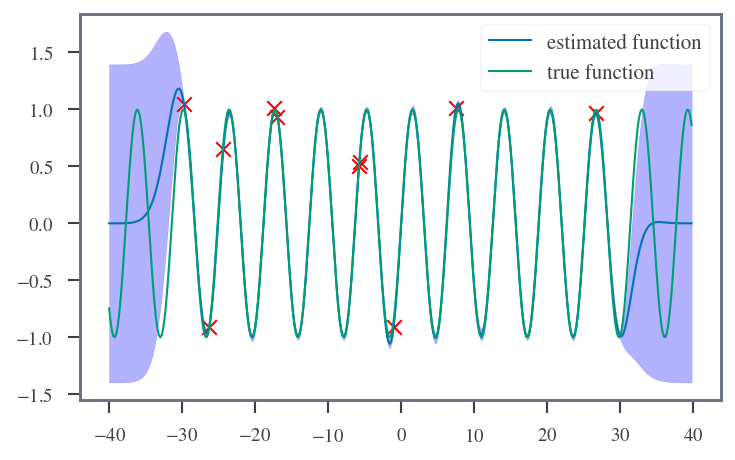

In [27]:
plt.plot(real_x, predicted_y, label="estimated function")
plt.fill_between(real_x, predicted_y - predicted_std, predicted_y + predicted_std, color="blue", alpha=0.3)
plt.scatter(x_data, y_data,c="red")
plt.plot(real_x, real_y, label="true function")
plt.legend()